<a href="https://colab.research.google.com/github/memed01/DataScienceAndBigData/blob/master/Mendi_LSTM_GRU_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### RNNs with Baseline, LSTM, GRU
In this work, we will use sunspot data and apply 3 different RNN types and rank them in terms of performance, we will only use the functional API of Keras

In [0]:
#%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import math

from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from math import sqrt
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.callbacks import EarlyStopping

from datetime import datetime

In [0]:
# fix random seed for reproducibility
np.random.seed(7)

1. Reading the data set, parsing the dates and inferring the date format to date time. We also fill the Nan’s with 0.

In [0]:
!wget https://storage.googleapis.com/nicksdemobucket/sunspots.csv

--2020-02-23 21:29:24--  https://storage.googleapis.com/nicksdemobucket/sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45039 (44K) [application/octet-stream]
Saving to: ‘sunspots.csv.1’

sunspots.csv.1      100%[===================>]  43.98K  --.-KB/s    in 0s      

2020-02-23 21:29:25 (153 MB/s) - ‘sunspots.csv.1’ saved [45039/45039]



In [0]:
# load the dataset
dataframe = pd.read_csv('sunspots.csv', engine='python')
dataset=dataframe['Sunspots']
dataset.index=dataframe['Month']

In [0]:
from pandas.tseries.offsets import MonthEnd
dataset.index = pd.to_datetime(dataset.index) + MonthEnd(1)

dataset.fillna(0, inplace=True)
values = dataset.values

In [0]:
# ensure all data is float
values = values.astype('float32')

Let's now take a glance at the data.

In [0]:
dataset.tail

<bound method NDFrame.tail of Month
1749-01-31    58.0
1749-02-28    62.6
1749-03-31    70.0
1749-04-30    55.7
1749-05-31    85.0
              ... 
1983-08-31    71.8
1983-09-30    50.3
1983-10-31    55.8
1983-11-30    33.3
1983-12-31    33.4
Freq: M, Name: Sunspots, Length: 2820, dtype: float64>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08db70898>],
      dtype=object)

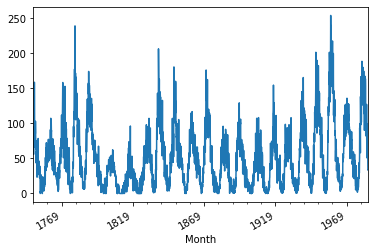

In [0]:
dataset.plot(subplots=True)

The DataFrame has 2820 rows, covering Monthly period from January, 2006 through December, 1983.

Sunspots observation have been recorded everyday, the dataset covering Monthly mean total sunspot from January 2006 through December 1983. 
This means that for one year you will have 12 observations.

### Baseline Predictions for Time Series Forecasting
https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/

A **rolling forecast** scenario will be used, also called **walk-forward model validation**.

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

#### Sliding Window

Let us create a lagged dataframe with shift() function
From a supervised learning perspective, the t-1 column is the input variable, or X, and the t+1 column is the output variable, or y.

In [0]:
# Create lagged dataset
values = DataFrame(dataset.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

    t-1   t+1
0   NaN  58.0
1  58.0  62.6
2  62.6  70.0
3  70.0  55.7
4  55.7  85.0


In [0]:
dataframe=dataframe.dropna(axis=0)
print(dataframe.head(5))

    t-1   t+1
1  58.0  62.6
2  62.6  70.0
3  70.0  55.7
4  55.7  85.0
5  85.0  83.5


In [0]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [0]:
train.shape,test.shape

((2254, 2), (564, 2))

In [0]:
# persistence model
def model_persistence(x):
	return x

In [0]:

#yhat = history[-1]
#history = [x for x in train]

Test MSE: 403.636


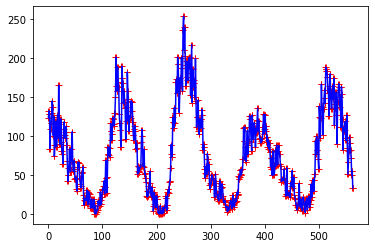

In [0]:
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)

# line plot of observed vs predicted
print('Test MSE: %.3f' % test_score)
pyplot.plot(test,'r+')
pyplot.plot(predictions,'b')
pyplot.show()

In [0]:
# plot predictions and expected results
#pyplot.plot(train_y)
#pyplot.plot([None for i in train_y] + [x for x in test_y])
#pyplot.plot([None for i in train_y] + [x for x in predictions])
#pyplot.show()


## LSTM Data Preparation
### Transform Time Series to Stationary

In [0]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [0]:
# transform to supervised learning
X = dataset.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

      0     0
0   0.0  58.0
1  58.0  62.6
2  62.6  70.0
3  70.0  55.7
4  55.7  85.0


With Series() function of pandas, let us remove a trend by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t).

In [0]:
from pandas import Series

In [0]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [0]:
# transform to be stationary
differenced = difference(dataset, 1)
print(differenced.head())

0     4.6
1     7.4
2   -14.3
3    29.3
4    -1.5
dtype: float64


In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [0]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [0]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

In [0]:
# fit LSTM network to training data
def fit_network(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1],train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    visible=tf.keras.layers.Input(batch_input_shape=(batch_size, X.shape[1], X.shape[2]))
    outputs=tf.keras.layers.LSTM(neurons, return_sequences=True)(visible)
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    outputs=tf.keras.layers.LSTM(neurons, return_sequences=True)(outputs)
    outputs=tf.keras.layers.Dense(1)(outputs)

    model1 = tf.keras.Model(inputs=visible, outputs=outputs)
    model1.compile(loss="mse", optimizer="adam")
    for i in range(nb_epoch):
        model1.fit(X, y, 
                   epochs=1, 
                   batch_size=batch_size,
                   verbose=1,
                  # callbacks=[early_stop], 
                   shuffle=False)
        model1.reset_states()
    return model1

In [0]:
# make a one-step forecast
def forecast_network(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [0]:
# transform data to be stationary
raw_values = dataset.values
diff_values = difference(raw_values, 1)

In [0]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [0]:
# split data into train and test-sets
train_size = int(len(supervised_values) * 0.80)
train, test = supervised_values[-train_size:], supervised_values[0:-train_size]

In [0]:
train.shape,test.shape

((2255, 2), (564, 2))

In [0]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Train on 2255 samples
2255/2255 [==============================] - 14s 6ms/sample - loss: 0.0388
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0387
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
1) Test RMSE: 24.397
Train on 2255 samples
2255/2255 [==============================] - 14s 6ms/sample - loss: 0.0388
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
2) Test R

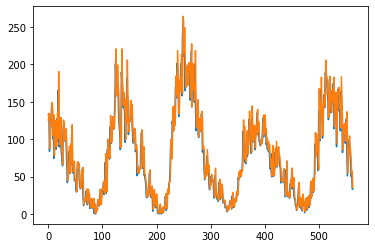

            rmse
count   1.000000
mean   21.536007
std          NaN
min    21.536007
25%    21.536007
50%    21.536007
75%    21.536007
max    21.536007


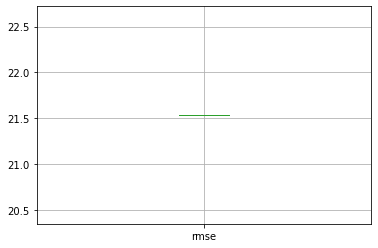

In [0]:
repeat=10
for r in range(repeat):
    error_scores = list()
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 5, 20)
      # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
      # make one-step forecast
      X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
      yhat = forecast_network(lstm_model, 1, X)
      # invert scaling
      yhat = invert_scale(scaler, X, yhat)
      # invert differencing
      yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
      # store forecast
      predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[(train_size+1):], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# line plot of observed vs predicted
pyplot.plot(raw_values[(train_size+1):])
pyplot.plot(predictions)
pyplot.show()

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

### GRUs Network

In [0]:
# fit an GRU network to training data
def fit_gru(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1],train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    visible=tf.keras.layers.Input(batch_input_shape=(batch_size, X.shape[1], X.shape[2]))
    outputs=tf.keras.layers.GRU(neurons, return_sequences=True)(visible)
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    outputs=tf.keras.layers.GRU(neurons, return_sequences=True)(outputs)
    outputs=tf.keras.layers.Dense(1)(outputs)

    model1 = tf.keras.Model(inputs=visible, outputs=outputs)
    model1.compile(loss="mse", optimizer="adam")
    for i in range(nb_epoch):
        model1.fit(X, y, 
                   epochs=1, 
                   batch_size=batch_size,
                   verbose=1,
                  # callbacks=[early_stop], 
                   shuffle=False)
        model1.reset_states()
    return model1

Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0388
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0387
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0386
1) Test RMSE: 21.446
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0388
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0387
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 12s 5ms/sample - loss: 0.0386
Train on 2255 samples
2255/2255 [==============================] - 11s 5ms/sample - loss: 0.0386
2) Test R

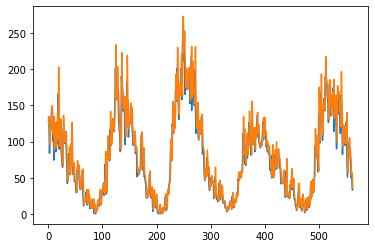

            rmse
count   1.000000
mean   22.455632
std          NaN
min    22.455632
25%    22.455632
50%    22.455632
75%    22.455632
max    22.455632


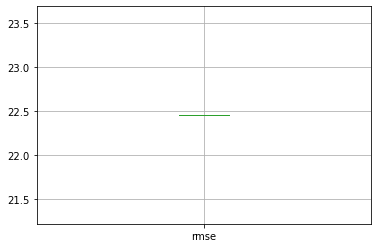

In [0]:
K.clear_session()
repeat=10
for r in range(repeat):
    error_scores = list()
    # fit the model
    gru_model = fit_gru(train_scaled, 1, 5, 20)
      # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    gru_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
      # make one-step forecast
      X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
      yhat = forecast_network(gru_model, 1, X)
      # invert scaling
      yhat = invert_scale(scaler, X, yhat)
      # invert differencing
      yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
      # store forecast
      predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[(train_size+1):], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
    
# line plot of observed vs predicted
pyplot.plot(raw_values[(train_size+1):])
pyplot.plot(predictions)
pyplot.show()

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

Results can be summarize:
1. **Baseline** Test MSE: 403.636
2. **LSTM** Test MSE: 21.54
3. **GRUs** Test MSE: 22.46



Predictions with LSTM Network give better score